In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Toggle code

In [2]:
%reset
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
pwd

'C:\\Users\\kovor\\Documents\\python\\pyXTel\\pySurf\\readers'

In [4]:
%qtconsole

In [3]:
import os
#from format_reader import read_ntmdt
import numpy as np
from matplotlib import pyplot as plt
from pySurf.data2D import plot_data

from dataIO.fn_add_subfix import fn_add_subfix



In [13]:
"""Set of functions to read .nid AFM data.
This is a first prototype, format is not standard."""

import numpy as npoints
from configparser import ConfigParser
import io
import struct
import numpy as np

""" dataset info     
Version=2
Points=256
Lines=256
Frame=Scan forward
CurLine=255
Dim0Name=X*
Dim0Unit=m
Dim0Range=1e-05
Dim0Min=0
Dim1Name=Y*
Dim1Unit=m
Dim1Range=1e-05
Dim1Min=0
Dim2Name=Z-Axis
Dim2Unit=m
Dim2Range=1.04e-05
Dim2Min=-5.2e-06
SaveMode=Binary
SaveBits=32
SaveSign=Signed
SaveOrder=Intel
"""

def read_raw_nid (file_name):
    """return header and raw data (all data blocks together) from file_name"""
   
    with open(file_name, 'rb') as binfile:
        lines = binfile.readlines()

    header=[]
    for i,l in enumerate(lines):
        text = l.decode('ansi')
        if '#!' in text:
            break
        header.append(text.strip())

    with open(file_name, 'rb') as binfile:
        a=binfile.read()
    i = a.find(b'#!')

    data = a[i+2:]
    
    return header,data

def read_datablock(data, npoints, nlines, nbits, nim=0, fmt = '<l'):
    """read image of index nim from binary data.
    nbits is redundant, can be obtained from fmt.
    fmt is c-style format string,
    see https://docs.python.org/3.5/library/struct.html#struct-format-strings for other formats
    """
    if nbits%8 != 0: raise ValueError
    imsize=npoints*nlines*nbits//8
    buf2 = io.BytesIO(data[nim*imsize:(nim+1)*imsize])
    idata = struct.iter_unpack(fmt,buf2.read())
    a=list(idata)
    img = np.array(a).reshape((nlines,npoints))
    return img

def read_nid(file_name):

    header, data = read_raw_nid(file_name) 
    from configparser import NoOptionError
    config = ConfigParser()
    buf = io.StringIO("\n".join(header))
    config.read_file(buf)
    ng = config.get('DataSet','GroupCount')

    # all columns of the matrix 
    ngroups = config.get('DataSet','GroupCount') #number of groups 
    imgdic={}
    i=0
    for g in range(int(ngroups)):    
        grcount = config.get('DataSet','Gr%i-Count'%g )
        # all raws of the actual column 
        for c in range(int(grcount)):     
            cgtag = 'Gr%i-Ch%i'%(g,c)
            try:
                datatag = config.get('DataSet',cgtag)
                # then read the header, specially �Points� and �Lines� 
                #ReadDataSetInfo(datatag)    
                npoints = int(config.get(datatag,'Points'))
                nlines = int(config.get(datatag,'Lines' ))
                nbits = int(config.get(datatag,'SaveBits'))
                sign = config.get(datatag,'SaveSign')
                if (int(nbits) != 32) or sign !='Signed':
                    raise ValueError
                else:
                    fmt = '<l'    
                img = read_datablock(data, npoints, nlines, nbits)
                
                #npoints nlines might be inverted
                Dim0Range = float(config.get(datatag,'Dim0Range'))
                Dim0Min = float(config.get(datatag,'Dim0Min'))
                x = np.arange(npoints) / (npoints-1)  * Dim0Range + Dim0Min
                
                Dim1Range = float(config.get(datatag,'Dim1Range'))
                Dim1Min = float(config.get(datatag,'Dim1Min'))
                y = np.arange(nlines) / (nlines-1) * Dim1Range + Dim1Min
                
                Dim2Range = float(config.get(datatag,'Dim2Range'))
                Dim2Min = float(config.get(datatag,'Dim2Min'))
                img = (img + 2**(nbits-1)) / (2**nbits-1) * Dim2Range + Dim2Min
                # z_value = (z_data + 2^(SaveBits-1)) / (2^SaveBits-1)  * Dim2Range + Dim2Min
                imgdic[cgtag] = [img,x,y]
                i=i+1
                units = [config.get(datatag,'Dim0Unit'),
                         config.get(datatag,'Dim1Unit'),
                         config.get(datatag,'Dim2Unit')]

                #print(points)
                #ReadBinData()
            except NoOptionError:
                #print('option '+cgtag+' not found')
                pass
            
    return imgdic

read_nid(f)


error: iterative unpacking requires a buffer of a multiple of 4 bytes

In [20]:
def read_nid(file_name):

    header, data = read_raw_nid(file_name) 
    from configparser import NoOptionError
    config = ConfigParser()
    buf = io.StringIO("\n".join(header))
    config.read_file(buf)
    ng = config.get('DataSet','GroupCount')

    # all columns of the matrix 
    ngroups = config.get('DataSet','GroupCount') #number of groups 
    imgdic={}
    i=0
    for g in range(int(ngroups)):    
        grcount = config.get('DataSet','Gr%i-Count'%g )
        # all raws of the actual column 
        for c in range(int(grcount)):     
            cgtag = 'Gr%i-Ch%i'%(g,c)
            try:
                datatag = config.get('DataSet',cgtag)
                # then read the header, specially �Points� and �Lines� 
                #ReadDataSetInfo(datatag)    
                npoints = int(config.get(datatag,'Points'))
                nlines = int(config.get(datatag,'Lines' ))
                nbits = int(config.get(datatag,'SaveBits'))
                sign = config.get(datatag,'SaveSign')
                if (int(nbits) != 32) or sign !='Signed':
                    raise ValueError
                else:
                    fmt = '<l'    
                img = read_datablock(data, npoints, nlines, nbits)
                
                #npoints nlines might be inverted
                Dim0Range = float(config.get(datatag,'Dim0Range'))
                Dim0Min = float(config.get(datatag,'Dim0Min'))
                x = np.arange(npoints) / (npoints-1)  * Dim0Range + Dim0Min
                
                Dim1Range = float(config.get(datatag,'Dim1Range'))
                Dim1Min = float(config.get(datatag,'Dim1Min'))
                y = np.arange(nlines) / (nlines-1) * Dim1Range + Dim1Min
                
                Dim2Range = float(config.get(datatag,'Dim2Range'))
                Dim2Min = float(config.get(datatag,'Dim2Min'))
                img = (img + 2**(nbits-1)) / (2**nbits-1) * Dim2Range + Dim2Min
                # z_value = (z_data + 2^(SaveBits-1)) / (2^SaveBits-1)  * Dim2Range + Dim2Min
                imgdic[cgtag] = [img,x,y]
                i=i+1
                units = [config.get(datatag,'Dim0Unit'),
                         config.get(datatag,'Dim1Unit'),
                         config.get(datatag,'Dim2Unit')]

                #print(points)
                #ReadBinData()
            except NoOptionError:
                #print('option '+cgtag+' not found')
                pass
            
    return imgdic

In [21]:
read_nid(f)

error: iterative unpacking requires a buffer of a multiple of 4 bytes

In [ ]:
# location of test input and output data,
#  for economy during development, hard coded path.
testfolder=r'..\test\input_data\AFM' 

#paths relative to testfolder
testdata = r'input_data\AFM\POLIMI\M12 no corona 50 nc_plane sub_20x20.mdt'
# testdata = r'input_data\AFM\POLIMI\M12 no corona 50 nc_plane sub_20x20.mdt'
testdata = r'input_data\AFM\POLIMI\M12 no corona 50 nc_plane sub_20x20.mdt'

outfolder='results'

In [8]:
datafolder = r'G:\My Drive\progetti\c_overcoating\esperimenti\20210129_dopamine\20210224_dopamine_clean'
df=['Image00087.nid']
f = os.path.join(datafolder,df[0])

In [9]:
read_nid(f)


error: iterative unpacking requires a buffer of a multiple of 4 bytes

In [2]:
from pySurf.data2D_class import Data2D


data,x,y = matrix_reader(f,delimiter='',skip_header=4)
D = Data2D(data,x,y,units=['um','um','m'],name=os.path.basename(f))



NameError: name 'os' is not defined

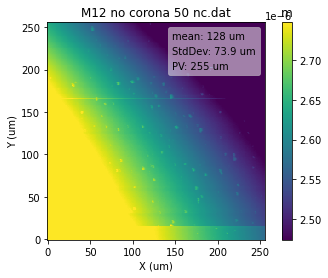

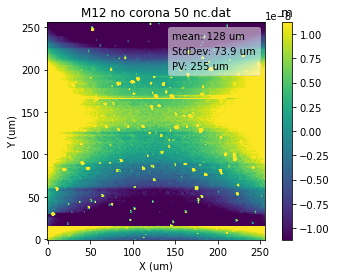

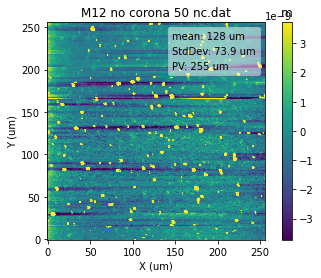

In [7]:
plt.figure(1)
D.plot(stats=1)
plt.show()
plt.figure(2)
D.level().plot(stats=1)
plt.show()
plt.figure(3)
D.level().level(2,axis=1).plot(stats=1)
plt.show()

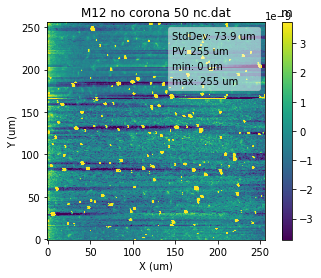

In [8]:
plt.clf()
D = D.level().level(2,axis=1)
D.plot()

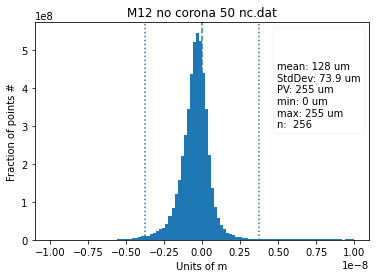

In [9]:
plt.figure('stats')
D.histostats(range=[-0.1e-7,0.1e-7]);

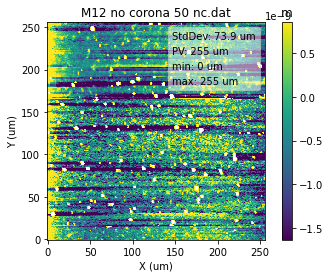

In [10]:
plt.figure()
D.remove_outliers(nsigma =3).plot()


In [12]:
from dataIO.outliers import remove_outliers
#test remove_outliers
dl,xl,yl = D()  # leveled data, `data,x,y` are raw data
plt.figure()
plot_data(remove_outliers(dl,nsigma=3,mask=False),xl,yl)


<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure()
plot_data(remove_outliers(dl,nsigma=3,mask=True),xl,yl)

<Figure size 432x288 with 0 Axes>

In [14]:
label_image = output_erosion.copy()
label_count = 0
rows, cols = label_image.shape
for j in range(rows):
    for i in range(cols):
        pixel = label_image[j, i]
        if 255 == pixel:
            label_count += 1
            cv.floodFill(label_image, None, (i, j), label_count)
print("Number of foreground objects", label_count)
cv.imshow("Connected Components", label_image)

NameError: name 'output_erosion' is not defined

In [15]:
D = Data2D(data,xrange=[0,20.08],yrange=[0,20.08],units=['um','um','m'])

In [16]:



%debug
D = Data2D(data,x,y,f,matrix_reader,units=['um','um','m'],name=f,delimiter='',skip_header=4)
D = Data2D(f,matrix_reader,units=['um','um','m'],name=f,delimiter='',skip_header=4)
D = Data2D(f,matrix_reader,units=['um','um','m'],name=f,delimiter='',skip_header=4)
f = filenames[10]
data,x,y = matrix_reader(f,delimiter='',skip_header=4)

D = Data2D(data,x,y,f,matrix_reader,units=['um','um','m'],name=f,delimiter='',skip_header=4)
f = filenames[10]
data,x,y = matrix_reader(f,delimiter='',skip_header=4)


D = Data2D(f,matrix_reader,units=['um','um','m'],name=f,delimiter='',skip_header=4)

> <ipython-input-14-4553816dcd33>(1)<module>()
----> 1 label_image = output_erosion.copy()
      2 label_count = 0
      3 rows, cols = label_image.shape
      4 for j in range(rows):
      5     for i in range(cols):

ipdb> c


AssertionError: 

In [17]:
d = Data2D()
d.load(f,matrix=True,skip_header=4,delimiter='')

from pySurf.data2D import data_from_txt
data_from_txt(f,matrix=True,skip_header=4,delimiter='')  #funziona

(array([[2.94880826e-06, 2.94795286e-06, 2.94526446e-06, ...,
         2.57524287e-06, 2.57487627e-06, 2.57353207e-06],
        [2.94795286e-06, 2.94636426e-06, 2.94465346e-06, ...,
         2.57487627e-06, 2.57389867e-06, 2.57292107e-06],
        [2.94807506e-06, 2.94673086e-06, 2.94611986e-06, ...,
         2.57402087e-06, 2.57340987e-06, 2.57206567e-06],
        ...,
        [2.64501907e-06, 2.64379707e-06, 2.64135307e-06, ...,
         2.27426428e-06, 2.27267568e-06, 2.27157588e-06],
        [2.64379707e-06, 2.64306387e-06, 2.64123087e-06, ...,
         2.27316448e-06, 2.27169808e-06, 2.27072048e-06],
        [2.64086427e-06, 2.64000887e-06, 2.63805367e-06, ...,
         2.27243128e-06, 2.27108708e-06, 2.26962068e-06]]),
 array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46

In [18]:
f = filenames[10]
data,x,y = matrix_reader(f,delimiter='',skip_header=4)

D = Data2D(data,x,y,units=['um','um','m'],name=f)

In [19]:
def show_content(filename):
    dl = ntmdt_reader(filename)

    from plotting.multiplots import subplot_grid
    plt.clf()
    fig,axes = subplot_grid(len(dl))
    plt.suptitle("Content of file %s:"%os.path.basename(filename))
    for d, ax in zip(dl,axes):
        plt.sca(ax)
        d.plot(stats = 1)

    plt.tight_layout()


In [20]:
import logging
logging.getLogger().setLevel(100)  #suppress logger output by changing the threshold for output

In [21]:
# Test on all files
for f in filenames:
    print("Processing ",f)
    try:
        show_content(f)
        plt.show()
    except:
        print("FAILED")

Processing  ..\readers\PyMDT\Test Files\test5.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\f14h20-mica.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\erythrocytes-aa.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\ferrite-garnet_film.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\graphene_2.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\plasmid_dna-aa.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\test_structure.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\curve_test.mdt
FAILED
Processing  ..\readers\PyMDT\Test Files\curve_test2.mdt
FAILED
Processing  ..\test\input_data\AFM\all data.mdt
FAILED
Processing  C:\Users\kovor\Documents\python\pyXTel\pySurf\test\input_data\AFM\gwyddion_converted\M12 no corona 50 nc.dat
FAILED
Processing  ..\test\input_data\AFM\POLIMI\M12 no corona 50 nc.mdt
FAILED
Processing  ..\test\input_data\AFM\POLIMI\M12 no corona 50 nc_plane sub_20x20.mdt
FAILED


In [147]:
import logging
logging.getLogger().setLevel(0)  #suppress logger output by changing the threshold for output

## OK fin qui

In [181]:
f = filenames[-2]
mdt_file = MDTFile()
mdt_file.load_mdt_file(f)

2020-09-22 15:09:35,114 -- INFO -- Reading frame 0


error: unpack requires a buffer of 2 bytes

In [163]:
"""(Pdb) frame.x_scale
[215175.21875, 784.313720703125, 0]

(Pdb) frame.y_scale
[200563.953125, 784.313720703125, 0]

(Pdb) frame.z_scale
[4004.12744140625, -0.12219999730587006, 65535]
"""

import struct
#s = '0b0100000000101001000101111000110101001111110111110011101101100100'
#q = int(s, 0)
#b8 = struct.pack('Q', q)
#struct.unpack('d', b8)[0]
 
val = 5241.43
hval = struct.pack('<e',val)
print(hval)

#e f d
formats=['>e','>f','>d','<e','<f','<d']

val = 784.313720703125
for f in formats:
    hval = struct.pack(f,val)
    print(f," ",hval.hex())

b'\x1em'
>e   6221
>f   44441414
>d   4088828280000000
<e   2162
<f   14144444
<d   0000008082828840


In [ ]:
mdt_file = MDTFile()
mdt_file.load_mdt_file(f)